In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from datetime import datetime, timezone
from tinkoff.invest import CandleInterval, Client
from tinkoff.invest.schemas import CandleSource

load_dotenv()
TOKEN = os.getenv("TOKEN")


In [15]:
with Client(TOKEN) as client:
    # get the USD rate
    for candle in client.get_all_candles(
        instrument_id="FUTUSDRUBF00",
        from_=datetime.now(timezone.utc),
        interval=CandleInterval.CANDLE_INTERVAL_DAY,
        candle_source_type=CandleSource.CANDLE_SOURCE_UNSPECIFIED,
    ):
        initial_usd_rate = candle.close.units + candle.close.nano / 1e9

interest_rate = float(input("Ставка по вкладу (% годовых): ").replace(',', '.'))
months = int(input("Срок вклада (в месяцах): "))
initial_rub = float(input("Сумма вклада (₽, например 1_000_000): ").replace(',', '_'))

# GBM model
mu = float(input("Ожидаемый среднегодовой дрейф курса (%, например 5): ").replace(',', '.')) / 100
sigma = float(input("Годовая волатильность курса (%, например 15): ").replace(',', '.')) / 100
n_simulations = 100_000
n_paths = 50
steps_per_month = 10


In [16]:
# processing
usd_initial = initial_rub / initial_usd_rate
growth_factor = 1 + (interest_rate / 100) * (months / 12)
final_rub = initial_rub * growth_factor
breakeven_rate = initial_usd_rate * growth_factor

# GBM
T = months / 12
N = int(months * steps_per_month)
dt = T / N

# trajectory
def gbm_path(S0, mu, sigma, T, N):
    dt = T / N
    Z = np.random.randn(N)
    path = [S0]
    for z in Z:
        s_next = path[-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
        path.append(s_next)

    return np.array(path)

paths = [gbm_path(initial_usd_rate, mu, sigma, T, N) for _ in range(n_paths)]

# monte-carlo
final_rates = initial_usd_rate * np.exp(
    (mu - 0.5 * sigma**2) * T + sigma * np.random.randn(n_simulations) * np.sqrt(T)
)
final_usd_values = final_rub / final_rates
profit_usd = (final_usd_values / usd_initial - 1) * 100


Итоги:
• Прирост капитала за срок: 17.33%
• Точка безубыточности: 94.68 ₽/$
• Средний курс по моделям через 13 мес: 88.11 ₽/$
• Средняя доходность в $: 12.25%
• Вероятность быть в плюсе (т.е. доходность больше нуля): 67.3%


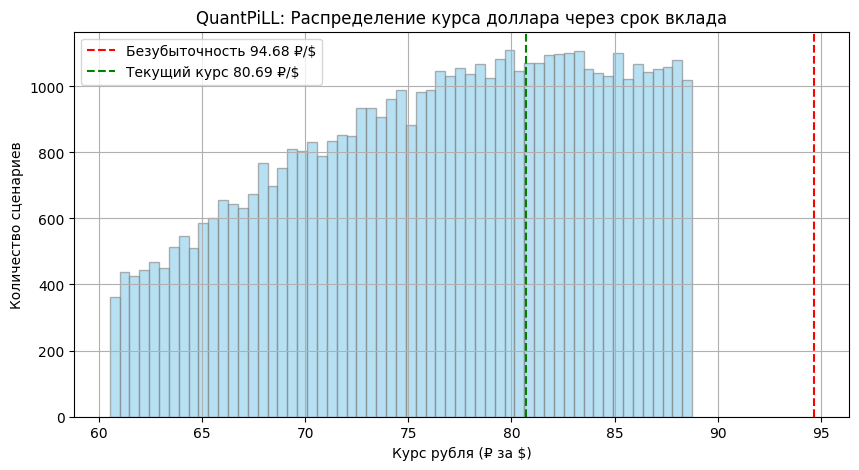

In [21]:
# result and plots
print("Итоги:")
print(f"• Прирост капитала за срок: {(growth_factor - 1) * 100:.2f}%")
print(f"• Точка безубыточности: {breakeven_rate:.2f} ₽/$")
print(f"• Средний курс по моделям через {months} мес: {np.mean(final_rates):.2f} ₽/$")
print(f"• Средняя доходность в $: {np.mean(profit_usd):.2f}%")
print(f"• Вероятность быть в плюсе (т.е. доходность больше нуля): {np.mean(profit_usd > 0) * 100:.1f}%")


plt.figure(figsize=(10, 5))
plt.hist(final_rates, bins=np.linspace(initial_usd_rate * 0.75, initial_usd_rate * 1.1, 60),
         alpha=0.6, color='skyblue', edgecolor='gray')
plt.axvline(breakeven_rate, color='red', linestyle='--', label=f'Безубыточность {breakeven_rate:.2f} ₽/$')
plt.axvline(initial_usd_rate, color='green', linestyle='--', label=f'Текущий курс {initial_usd_rate:.2f} ₽/$')
plt.title("QuantPiLL: Распределение курса доллара через срок вклада")
plt.xlabel("Курс рубля (₽ за $)")
plt.ylabel("Количество сценариев")
plt.legend()
plt.grid(True)
plt.show()
